<a href="https://www.kaggle.com/code/mauddib/dexcomg7-cgm-vs-carbs-satiety-index?scriptVersionId=223855966" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents

Part 1

1. [Medical Disclaimer](#disclaimer)
2. [Preamble and loading the data](#loaddata)
3. [Describe the basics of your glucose data through boxplots](#gludat)
4. [The carbohydrate test](#carb)
5. [The coefficient of variation (CV)](#cv)
6. [Exercise influence](#exercise)
7. [Part 1 Conclusion](#conclusion)

Part 2

1. [Analytical Strategy](#inspect)
2. [Satiety Index Regression](#satiety)
3. [Nutrient Density Regression](#nutrient)
4. [Glucose Score Regression](#glucose)
5. [Predicting satiety index, nutrient density and glucose score in my food data](#predicting)



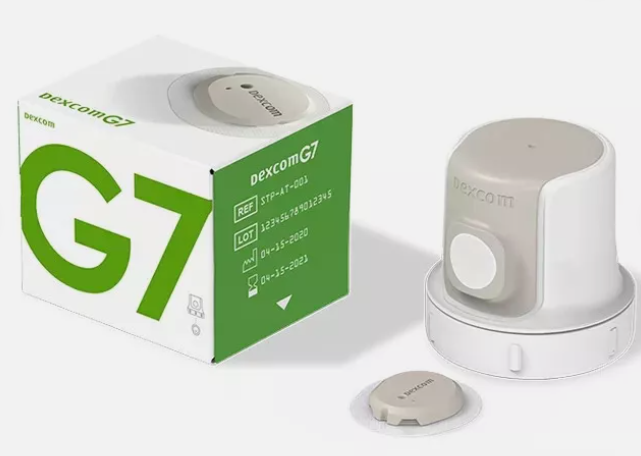

# 1. Medical Advice Disclaimer <a class="anchor"  id="disclaimer"></a>
This code/analysis does not contain medical advice. The information, including but not limited to text, graphics, images, and other material contained in this program are for informational purposes only. No material in this program is intended to be a substitute for professional medical advice, diagnosis or treatment. Always seek the advice of your physician or qualified health care provider with any questions you may have regarding a medical condition or treatment and before undertaking a new health care regimen, and never disregard professional medical advice or delay in seeking it because of something you have read or learned here.


# 2. Preamble and loading the data <a class="anchor"  id="loaddata"></a>

I wore a Dexcom G7 sensor for the period 31 Jan 2025 to 10 Feb 2025. I am not diagnosed as diabetic or even pre-diabetic or anything similar, I merely wanted to understand my body's glucose response to various foods and exercise. 

The data exported from the sensor can be found in the file beginning with Clarity_Export_. The sensor itself only works for 10 days with a grace period of 12 hrs, which is why you will see data for 11 days, from around 10 am on friday the 31st Jan 2025 to 8pm on 10th Feb 2025. What I sought to do during the 10 days was understand the impact on my glucose levels different foods had. I also deliberately ate carbs as per normal for the first period 5 days, and then roughly halved my carb intake for the 2nd period of 5 days. So we basically have an AB test the effects of which we can look for in the data. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime
from matplotlib.dates import date2num

%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dexcom-sensor-data/Clarity_Export_2025-02-11_032331.csv
/kaggle/input/food-and-satiety-index/foods_data.csv
/kaggle/input/food-and-satiety-index/food_glucose_data.csv
/kaggle/input/food-and-satiety-index/net carbs vs glucose score vs satiety index_data_.csv


#### Load the Dexcom data

Note you need to remove the first 12 lines of non data...

In [2]:
import warnings
warnings.filterwarnings("ignore")

# SELECT YOUR OWN CSV FILE BELOW:
df = pd.read_csv('/kaggle/input/dexcom-sensor-data/Clarity_Export_2025-02-11_032331.csv', index_col = 0)

glucose = df[['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mmol/L)']]
glucose = glucose.drop([1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12])

glucose.reset_index(drop=True, inplace=True)
glucose['Timestamp (YYYY-MM-DDThh:mm:ss)'] = pd.to_datetime(glucose['Timestamp (YYYY-MM-DDThh:mm:ss)'])

glucose = glucose.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)' : 'Timestamp'})
glucose['Glucose Value (mmol/L)'] = glucose['Glucose Value (mmol/L)'].astype(float)
glucose = glucose.dropna()
glucose.head()

,Timestamp,Glucose Value (mmol/L)
0,2025-01-31 10:38:43,5.4
1,2025-01-31 10:43:43,5.6
2,2025-01-31 10:48:43,5.7
3,2025-01-31 10:53:42,5.9
4,2025-01-31 10:58:43,5.9


# 3. describe the basics of your glucose data in one boxplot <a class="anchor"  id="gludat"></a>

<Figure size 1000x400 with 0 Axes>

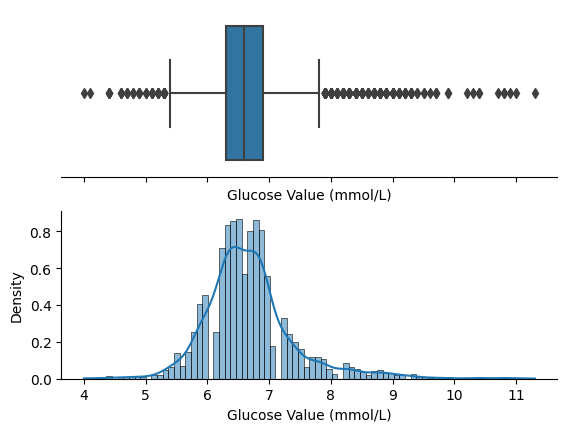

In [3]:
plt.figure(figsize=(10,4))


f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.5, .5)})

sns.boxplot(x=glucose['Glucose Value (mmol/L)'], ax=ax_box)
sns.histplot(x=glucose['Glucose Value (mmol/L)'], bins=80, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)


From the above we can see the average glucose sat somehwere between 6 and 7 mmol/L for the most part. Let's break that down by day:

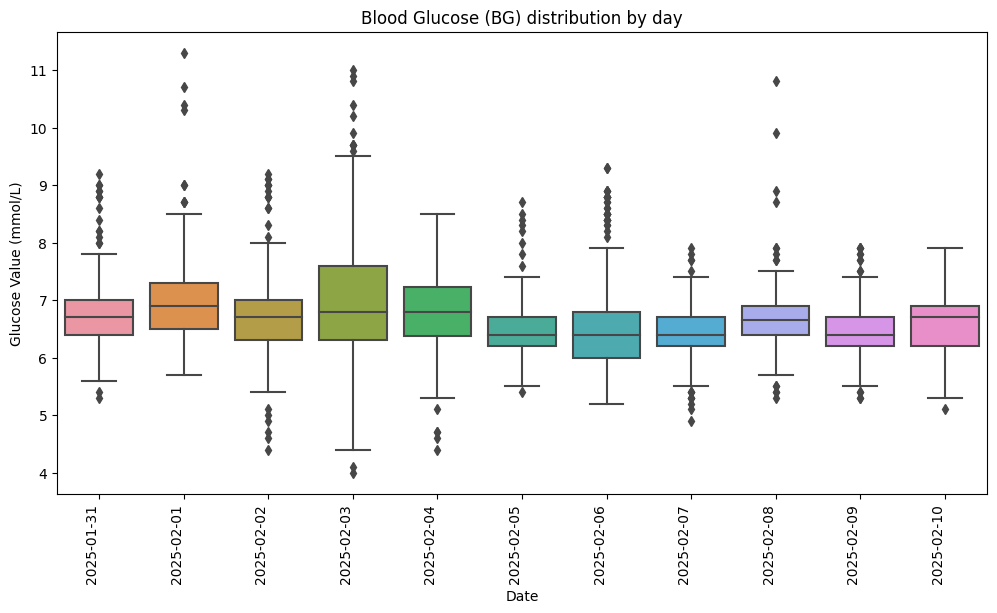

In [4]:
plt.figure(figsize=(12,6))
glucose['Day'] = glucose['Timestamp'].dt.day_name()
glucose['Date'] = glucose['Timestamp'].dt.date
sns.boxplot(x= glucose['Date'],y=glucose['Glucose Value (mmol/L)'])
plt.title('Blood Glucose (BG) distribution by day')
plt.xticks(rotation=90, ha='right');

# 4. The carbohydrate test <a class="anchor"  id="carb"></a>

OK lets compare the first 5 days to the second 5 days, by creating a variable and then plotting. Remember, for the first 5 days I ate carbs normally (denoted by 'Normal' category in graph), and even tested a sweets and coke combo on one day, while during the 2nd 5 days I halved my daily carb intake from around 200 grams/day to 100 grams/day (denoted by 'Lower' category in below graphs).

Let's import my carb intake data and visualize the carb intake by period.

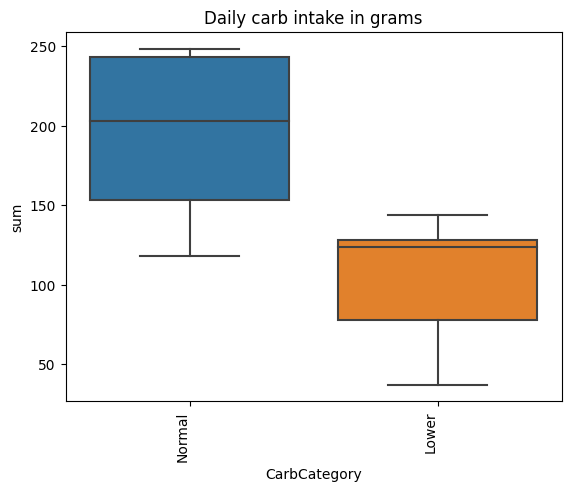

In [5]:
diet = pd.read_csv('/kaggle/input/food-and-satiety-index/food_glucose_data.csv')

diet = diet[diet['date'] !='09/02/2025']
agg_diet = diet.groupby(['date'])['carbs'].agg(['sum']).reset_index()

agg_diet['date'] = pd.Categorical(agg_diet['date'], ['31/01/2025','01/02/2025','02/02/2025','03/02/2025','04/02/2025','05/02/2025','06/02/2025','07/02/2025','08/02/2025','09/02/2025'])
agg_diet = agg_diet.sort_values(by='date')

agg_diet['date'] = agg_diet['date'].astype(str)
agg_diet['CarbCategory'] = np.where(agg_diet['date'] <= '04/02/2025','Normal','Lower')
agg_diet_ = agg_diet[agg_diet['date'] != '09/02/2025']
sns.boxplot(x=agg_diet_['CarbCategory'].sort_values(ascending=False),y=agg_diet_['sum'])
plt.title('Daily carb intake in grams');
plt.xticks(rotation=90, ha='right');


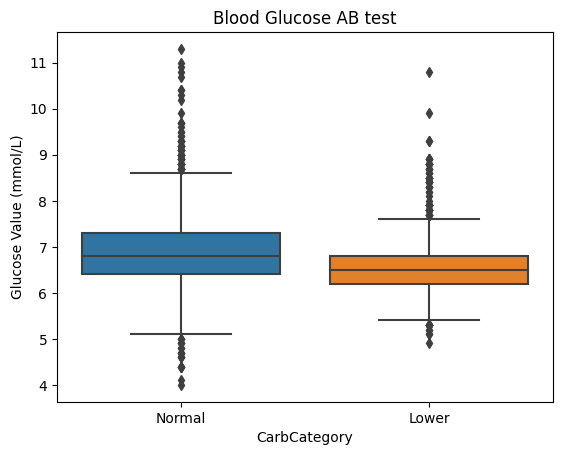

In [6]:
glucose['Date'] = glucose['Date'].astype(str)
glucose['CarbCategory'] = np.where(glucose['Date'] <= '2025-02-04','Normal','Lower')
sns.boxplot(x=glucose['CarbCategory'],y=glucose['Glucose Value (mmol/L)'])
plt.title('Blood Glucose AB test');

From the above you can see that the 2nd period of 'Lower' carbohydrate intake corresponds with a tighter range of blood glucose (BG) readings and also a lower IQR and median. Another dimension that can be analysed is the coefficient of variation. Since the above effect looks small let's run a t-test to see if the two sample means differ significantly:

#### Simple T-Test

In [7]:
from scipy import stats

group1 = glucose[glucose['CarbCategory'] == 'Normal']['Glucose Value (mmol/L)'].astype(float)
group2 = glucose[glucose['CarbCategory'] == 'Lower']['Glucose Value (mmol/L)'].astype(float)[:len(group1)]

t_stat, p_value = stats.ttest_ind(group2, group1,equal_var=False)

print(f"Carb test t-statistic: {t_stat:.4f}")
print(f"Carb test p-value: {p_value:.4f}")

Carb test t-statistic: -12.8811
Carb test p-value: 0.0000


Here’s what these numbers mean:
- The negative t-statistic tells us eating less carbs corresponds with lower BG readings (note order in test)
- The tiny p-value (< 0.01) means this difference is statistically significant
- We can say with 99% confidence that carbs affect BG levels, no surprises here!

# 5. The coefficient of variation (CV) <a class="anchor"  id="carb"></a>

The "coefficient of variation" on blood glucose (BG) levels, often abbreviated as "CV", is a metric used to assess the degree of variability in blood sugar levels over a period of time, essentially showing how much a person's blood sugar fluctuates relative to their average blood sugar level, and is calculated by dividing the standard deviation of glucose readings by the mean glucose level, expressed as a percentage.
A higher CV indicates greater blood sugar variability, meaning larger swings between high and low glucose levels. 

Key points about the coefficient of variation (CV) in blood glucose levels:

* What it measures: The extent of fluctuations in blood sugar levels, regardless of the absolute average glucose value. 
* How it's calculated: (Standard deviation of glucose readings) / (mean glucose level) x 100%. 
* Interpretation:

Low CV: Indicates relatively stable blood sugar levels with minimal fluctuations. 

High CV: Represents significant variations in blood sugar levels, potentially increasing the risk of complications like hypoglycemia. 


In [8]:
def std(x): 
    return np.std(x)

df_cv = glucose.groupby('Date')['Glucose Value (mmol/L)'].agg(['mean', 'max', std]).reset_index()
df_cv['glucose_cv'] = df_cv['std']/df_cv['mean']
df_cv.head(10)

,Date,mean,max,std,glucose_cv
0,2025-01-31,6.808696,9.2,0.732510,0.107584
1,2025-02-01,7.001736,11.3,0.791511,0.113045
2,2025-02-02,6.732292,9.2,0.728082,0.108148
3,2025-02-03,7.027431,11.0,1.181473,0.168123
4,2025-02-04,6.827431,8.5,0.716360,0.104924
5,2025-02-05,6.446875,8.7,0.509756,0.079070
6,2025-02-06,6.562153,9.3,0.860954,0.131200
7,2025-02-07,6.425000,7.9,0.456740,0.071088
8,2025-02-08,6.677431,10.8,0.531779,0.079638
9,2025-02-09,6.459722,7.9,0.466565,0.072227


Text(0.5, 1.0, 'BG CV by carbohydrate intake category')

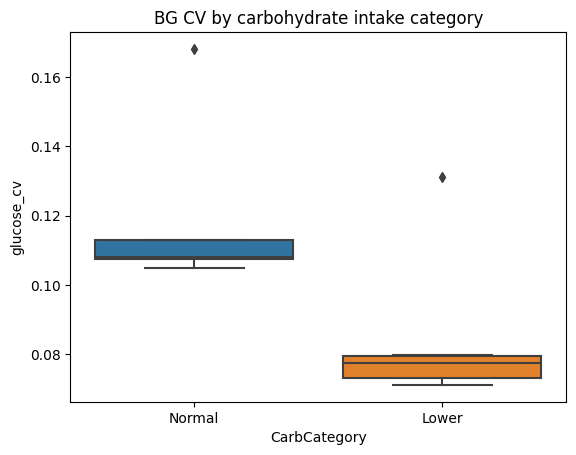

In [9]:
df_cv['CarbCategory'] = np.where(df_cv['Date'] <= '2025-02-04','Normal','Lower')

sns.boxplot(x=df_cv['CarbCategory'],y=df_cv['glucose_cv'])
plt.title('BG CV by carbohydrate intake category')

As a table of values:

In [10]:
df_cv1 = glucose.groupby('CarbCategory')['Glucose Value (mmol/L)'].agg(['mean', 'max', std]).reset_index()
df_cv1['glucose_cv'] = df_cv1['std']/df_cv1['mean']
(df_cv1.sort_values(by='CarbCategory', ascending=False)).style.highlight_min(color='lightgreen')

,CarbCategory,mean,max,std,glucose_cv
1,Normal,6.886367,11.300000,0.867307,0.125945
0,Lower,6.526509,10.800000,0.580437,0.088935


From the above you can see how reducing carbs by half decreases variability appreciably.

# 6. Exercise influence on BG readings <a class="anchor"  id="exercise"></a>

During the sensor period, two saturdays were spanned, which meant that I could understand what impact the runs would have on my BG levels if any. I run the standard 9am 5km park run most saturdays, which I started doing a year ago odd.

In [11]:
glucose['datetime'] = pd.to_datetime(glucose['Timestamp'], format='%Y-%m-%d %H:%M:%S')
glucose['hour'] = glucose['datetime'].dt.hour
glucose['min'] = glucose['datetime'].dt.minute

Lets carve out the two saturday periods between 7 am and noon. During this period, i typically wake up and have a coffee, then do the run, then go shopping before I finally head home and eat for the first time around noon odd.

In [12]:
parkrun1 = pd.DataFrame(glucose[(glucose['datetime'].dt.hour >= 7)&(glucose['datetime'].dt.hour <= 11)&(glucose['Date'] == '2025-02-01')][['hour','min','Glucose Value (mmol/L)']])
parkrun1['hour_min'] = parkrun1['hour'].astype(str) + '_' + parkrun1['min'].astype(str)
parkrun1 = parkrun1.set_index('hour_min')
parkrun2 = pd.DataFrame(glucose[(glucose['datetime'].dt.hour >= 7)&(glucose['datetime'].dt.hour <= 11)&(glucose['Date'] == '2025-02-08')][['hour','min','Glucose Value (mmol/L)']])
parkrun2['hour_min'] = parkrun2['hour'].astype(str) + '_' + parkrun2['min'].astype(str)
parkrun2 = parkrun2.set_index('hour_min')

result = pd.merge(parkrun1, parkrun2, on=['hour','min'], how='outer')
result['hour_min'] = result['hour'].astype(str) + '_' + result['min'].astype(str)
result = result.set_index('hour_min')
result.head(2)

,hour,min,Glucose Value (mmol/L)_x,Glucose Value (mmol/L)_y
hour_min,,,,
7_3,7,3,7.0,6.9
7_8,7,8,6.9,NaN


Now lets overlay the two lines of the BG levels:

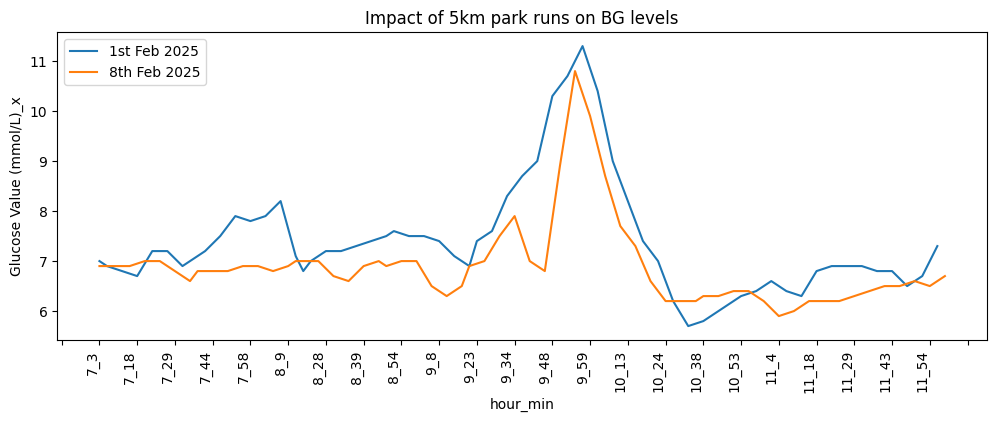

In [13]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(12,4))
ax = sns.lineplot(result['Glucose Value (mmol/L)_x'],label='1st Feb 2025')
ax = sns.lineplot(result['Glucose Value (mmol/L)_y'],label='8th Feb 2025')
ax.xaxis.get_major_locator()                    
ax.xaxis.get_major_formatter()        
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.title('Impact of 5km park runs on BG levels')
plt.legend(loc='upper left')
plt.xticks(rotation=90, ha='right');


Surprisingly, the 2 runs resulted in the HIGHEST BG readings over the entire sensor period! Interesting!

# 7. Part 1 Conclusion <a class="anchor"  id="conclusion"></a>

In conclusion it has been a great learning experience, if anything I am very keen to keep my CV down! And I'm not done because I still have a lot more data to analyse, such as glucose vs satiety index and nutrient density, so look out for a part two. Just look at these juicy headers!:

In [14]:
diet.tail(9)

,date,time,food,kcal,fat,carbs,protein,fat.1,carbs.1,protein.1,exercise,glucose_init,glucose_final
98,08/02/2025,11:30,dark rye sourdough bread x 1,117.0,0.65,22.0,4,0.024390,0.825516,0.150093809,0,NaN,NaN
99,08/02/2025,11:30,mackerel in tomato sauce,247.5,17.50,9.5,12.875,0.438871,0.238245,0.322884013,0,NaN,NaN
100,08/02/2025,11:30,popcorn small,31.0,0.40,6.2,1,0.052632,0.815789,0.131578947,0,NaN,NaN
101,08/02/2025,13:30,coffee,86.0,3.40,8.5,5.5,0.195402,0.488506,0.316091954,0,6.5,7.5
102,08/02/2025,17:50,2 carb lite wraps,127.0,6.40,29.2,13.8,0.129555,0.591093,0.279352227,0,6.2,7.0
103,08/02/2025,17:50,beef,148.0,8.90,0.0,16.3,0.353175,0.000000,0.646825397,0,NaN,NaN
104,08/02/2025,17:50,spinach leaves,7.0,0.10,1.1,0.9,0.047619,0.523810,0.428571429,0,NaN,NaN
105,08/02/2025,17:50,rum n coke,253.0,0.10,26.2,0.2,0.003774,0.988679,0.00754717,0,NaN,NaN
106,08/02/2025,17:50,popcorn,31.0,0.40,6.2,1,0.052632,0.815789,0.131578947,0,NaN,NaN


# Part 2

# Satiety Index, Nutrient Density and Glucose Score

# 1. Food Score strategy<a class="anchor"  id="inspect"></a>

So we are going to look at the dataset that I collected while wearing the cgm. I managed to collect the protein, fat and carb splits per meal, along with the energy measured in kcals as can be seen above. I have also managed to download some of Marty Kendall's famous satiety index data, along with nutrient density and glucose score data. 

What I am going to do is build a scoring system across all 3 dimensions (satiety index, nutrient density and glucose score), and then see how that correlates with the dexcom g7 glucose readings. 

# 2. Satiety Index <a class="anchor"  id="satiety"></a>

Let's import a dataset from Marty Kendals website that contains all 3 scores: 
https://public.tableau.com/app/profile/marty.kendall7139/viz/NetCarbsvsGlucoseScorevsSatietyIndex/netcarbsvsglucosescorevssatietyindex

You can find it here in the book called "net carbs vs glucose score vs satiety index_data_.csv"

So firstly we will need to build a regression model to predict the satiety index off of Marty Kendall's data, and then apply it to my food data that I collected over the period I wore the cgm sensor.

In [15]:
foods_data = pd.read_csv('/kaggle/input/food-and-satiety-index/net carbs vs glucose score vs satiety index_data_.csv')
foods_data.dtypes

Gs (%)                              float64
Protein %                           float64
Category                             object
Fii (%)                             float64
Food                                 object
Gi (%)                              float64
Nutrient Density (Per Serving)      float64
Popularity                           object
satiety index score                 float64
Serving Size (Cal)                  float64
Category.1                           object
Nutrient Density (Per Calorie)      float64
Protein %.1                         float64
Fat (%)                             float64
Fibre (%)                           float64
Gs (%).1                            float64
Net Carb (%)                        float64
Nutrient Density (Per Calorie).1    float64
Protein %.2                         float64
satiety index score.1               float64
satiety index score.2               float64
dtype: object

In [16]:
diet['protein.1'] = np.where(diet['protein.1'] == '#VALUE!',0,diet['protein.1'])

Now in my data set I was able to capture the Kcal, protein in grams, fat in grams and carbs in grams. In Martys set we have the same variables in some form (as % in fact). One thing we can do to ensure we have the variables on the same footing is to turn them both into proportions. And then we can be confident our predictions are meaningful.

In [17]:
foods_data['protein_'] = foods_data['Protein %']/(foods_data['Protein %']+foods_data['Fat (%)']+foods_data['Net Carb (%)'])
foods_data['fat_'] = foods_data['Fat (%)']/(foods_data['Protein %']+foods_data['Fat (%)']+foods_data['Net Carb (%)'])
foods_data['carbs_'] = foods_data['Net Carb (%)']/(foods_data['Protein %']+foods_data['Fat (%)']+foods_data['Net Carb (%)'])
foods_data['satiety_index'] = foods_data['satiety index score']
foods_data['Gs_'] = foods_data['Gs (%)']
foods_data['nutrient_density_per_cal'] = foods_data['Nutrient Density (Per Calorie)']
foods_data.head(3)

,Gs (%),Protein %,Category,Fii (%),Food,Gi (%),Nutrient Density (Per Serving),Popularity,satiety index score,Serving Size (Cal),...,Nutrient Density (Per Calorie).1,Protein %.2,satiety index score.1,satiety index score.2,protein_,fat_,carbs_,satiety_index,Gs_,nutrient_density_per_cal
0,0.329822,0.516628,plants,0.138060,Spinach,0.347710,0.389422,very popular,1.000000,26.535513,...,0.915710,0.516628,1.000000,1.000000,0.604438,0.119140,0.276422,1.000000,0.329822,0.915710
1,0.322535,0.520072,plants,0.204749,Bok Choy (Cooked),0.335469,0.251789,very popular,0.986954,17.797468,...,0.875153,0.520072,0.986954,0.986954,0.579862,0.134036,0.286102,0.986954,0.322535,0.875153
2,0.321290,0.836319,plants,0.425139,Watercress,0.296462,0.151709,very popular,0.983598,5.133919,...,0.874561,0.836319,0.983598,0.983598,0.693667,0.068540,0.237793,0.983598,0.321290,0.874561


OK let's run some correlations on our new variables as well as the satiety index that we want to run a regression model on to predict values for our food data. 

First let's define a correlation function:

In [18]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

Now run the correlation:

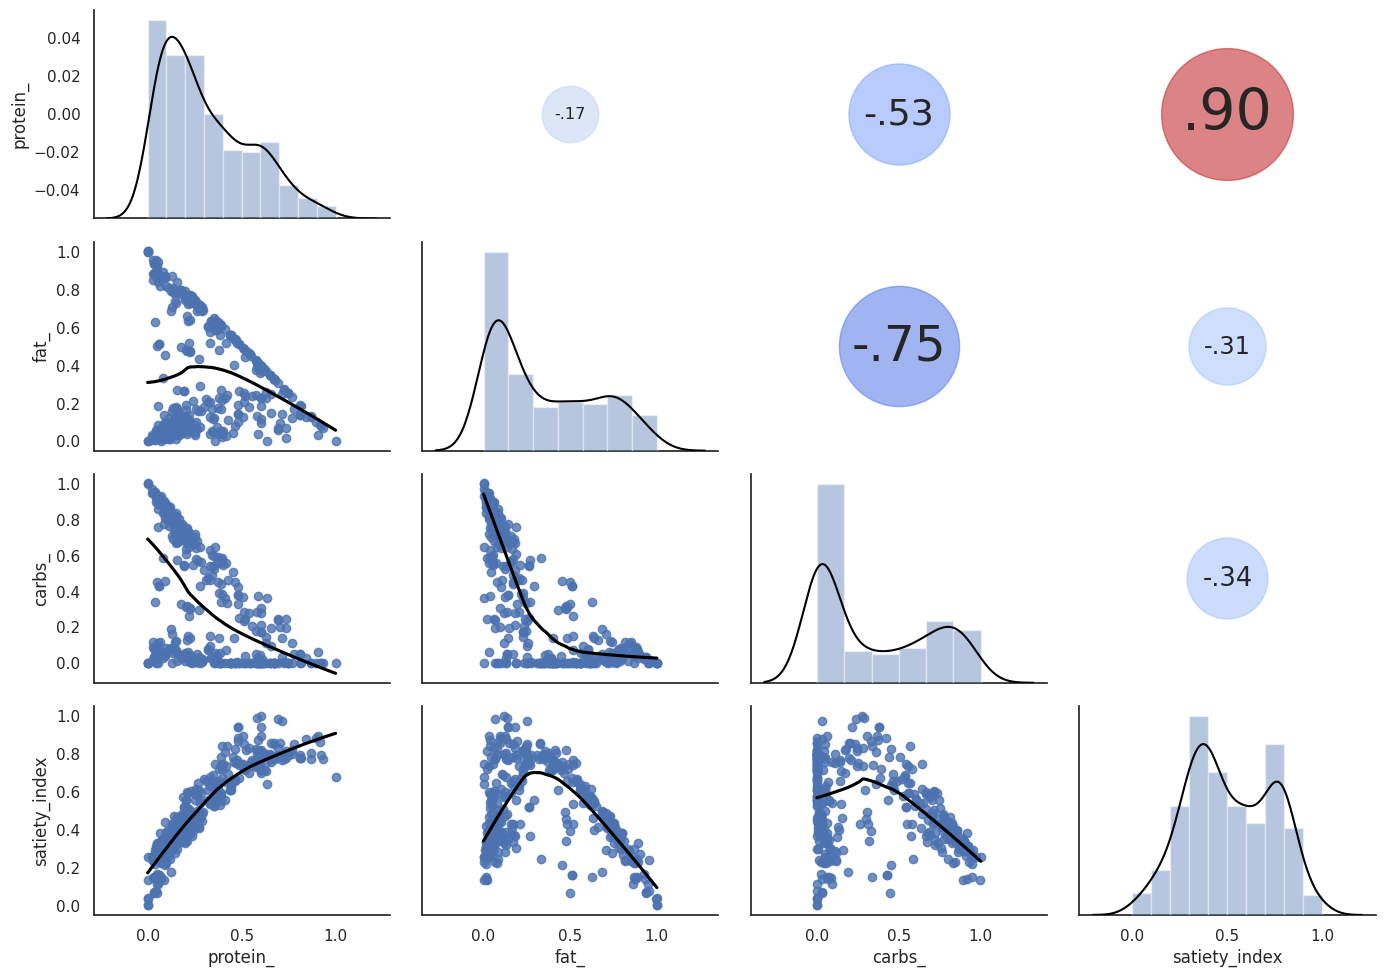

In [19]:
corr_data = foods_data[['protein_','fat_','carbs_','satiety_index']]

sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(corr_data, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

The protein porportion is highly correlated to the satiety index, in fact, the satiety index seems to be largely based on the protein proportion of foodstuffs.
Well some of those relationships aren't perfectly linear, but lets give it a bash using a test and validation set. I'll add two interaction effects for the two most negative correlations (they seem to be undoing the linearity of things) to the regression model, namely protein vs carbs and protein vs fat.

In [20]:
from statsmodels.formula.api import ols,rlm
from sklearn.model_selection import train_test_split

#rename some fields to make them easier to use in future:
foods_data['Gs_'] = foods_data['Gs (%)']
foods_data['nutrient_density_per_cal'] = foods_data['Nutrient Density (Per Calorie)']

idx_train, idx_validation = train_test_split(foods_data.index,test_size=0.15, random_state=42)
foods_data_train = foods_data.loc[idx_train]
foods_data_validation = foods_data.loc[idx_validation]

model_satiety = ols(formula = '(satiety_index) ~ protein_+ fat_+ carbs_+ protein_:carbs_ + fat_:protein_', data=foods_data_train).fit()
model_satiety.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          satiety_index   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     969.5
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          4.81e-169
Time:                        06:38:30   Log-Likelihood:                 426.74
No. Observations:                 302   AIC:                            -843.5
Df Residuals:                     297   BIC:                            -824.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2519      0.008     30.621      0.000       0.236       0.268
protein_            0.5365      0.015     35.725      0.000       0.507       0.566
fat_               -0.1980      0.011    -18.702      0.000      -0.219      -0.177
carbs_             -0.0866      0.011     -8.040      0.000      -0.108      -0.065
protein_:carbs_     1.3516      0.074     18.283      0.000       1.206       1.497
fat_:protein_       1.0873      0.076     14.388      0.000       0.939       1.236
==============================================================================
Omnibus:                        9.730   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.055
Skew:                          -0.125   Prob(JB):                     0.000198
Kurtosis:                       4.137   Cond. No.                     2.52e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.43e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

A decent fit indeed as per multiple coefficient of determination (R-squared and Adj R-squared). All the coefficients are significant too. The real litmus test though is in predicting the vaildation set nicely though:

In [21]:
preds = model_satiety.predict(foods_data_validation)

### Plot the validation predictions vs actual values:

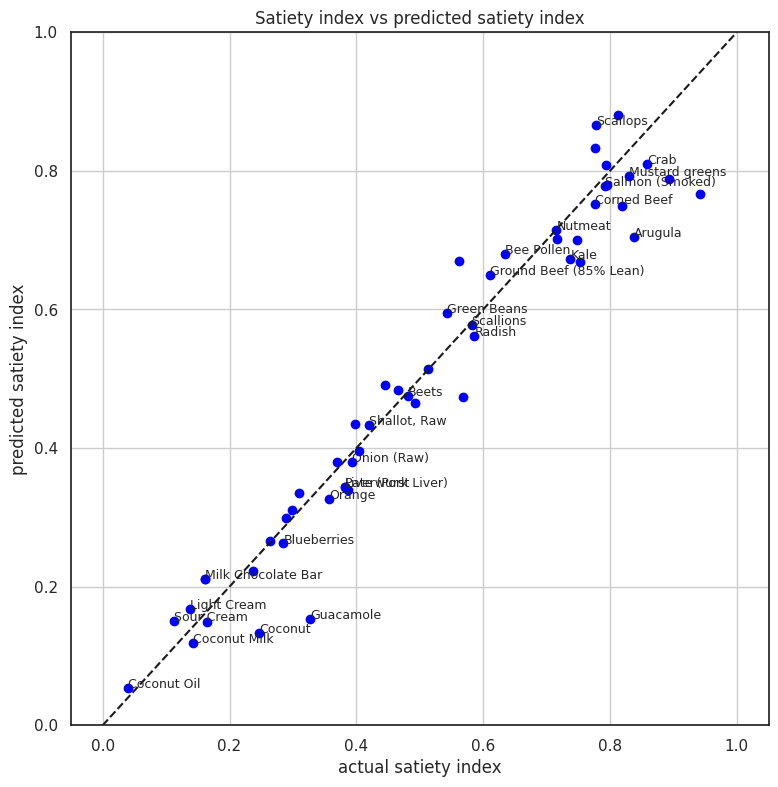

In [22]:
fig, ax = plt.subplots(figsize=(9,9))
foods = foods_data_validation['Food']
plt.scatter(foods_data_validation['satiety_index'],preds,color = "blue")
for count, label, xx, yy in zip(np.arange(len(foods_data_validation)),foods, foods_data_validation['satiety_index'],preds):
    if count % 2 == 0:
        plt.annotate(label, xy = (xx, yy),fontsize = 9)
plt.grid(True)
plt.ylim(0,1)
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('actual satiety index')
plt.ylabel('predicted satiety index')
plt.title('Satiety index vs predicted satiety index')
plt.show()

A decent fit on the vaildation set indeed. I'm sold. Onwards!

# 3. Nutrient Density <a class="anchor"  id="nutrient"></a>

In [23]:

model_nutden = ols(formula = 'nutrient_density_per_cal ~ -1 + protein_+ fat_+ carbs_+ protein_:carbs_ + fat_:carbs_ + satiety_index', data=foods_data_train).fit()
model_nutden.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     nutrient_density_per_cal   R-squared:                       0.797
Model:                                  OLS   Adj. R-squared:                  0.793
Method:                       Least Squares   F-statistic:                     231.8
Date:                      Sat, 22 Feb 2025   Prob (F-statistic):          4.41e-100
Time:                              06:38:31   Log-Likelihood:                 327.23
No. Observations:                       302   AIC:                            -642.5
Df Residuals:                           296   BIC:                            -620.2
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
protein_           -0.1456      0.067     -2.174      0.031      -0.277      -0.014
fat_                0.0879      0.020      4.430      0.000       0.049       0.127
carbs_              0.0310      0.020      1.559      0.120      -0.008       0.070
protein_:carbs_     0.2439      0.117      2.084      0.038       0.014       0.474
fat_:carbs_         0.2725      0.132      2.068      0.040       0.013       0.532
satiety_index       0.9041      0.062     14.563      0.000       0.782       1.026
==============================================================================
Omnibus:                       65.898   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.270
Skew:                          -0.955   Prob(JB):                     5.36e-44
Kurtosis:                       6.491   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
preds = model_nutden.predict(foods_data_validation)

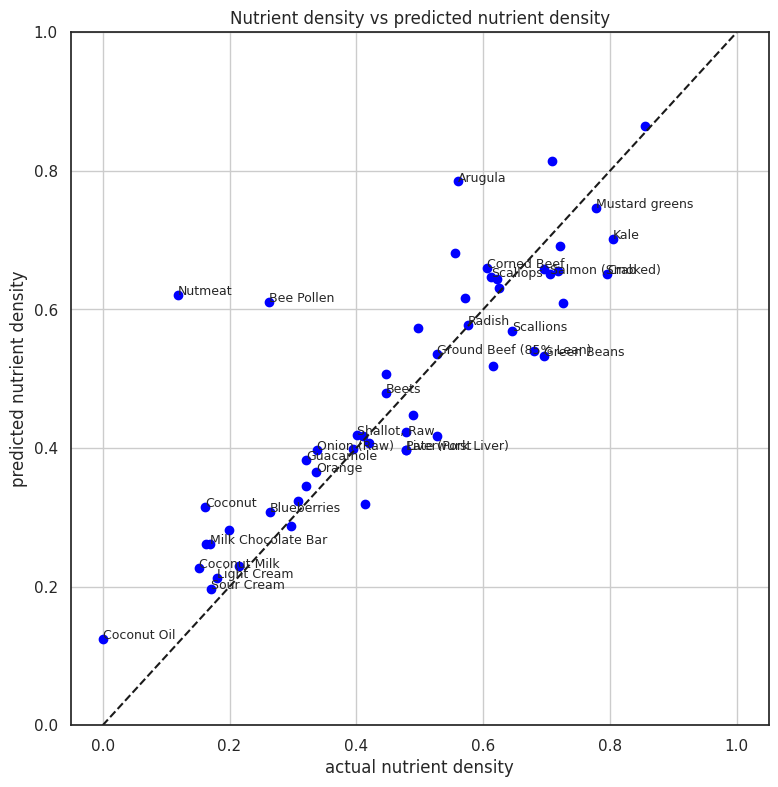

In [25]:
fig, ax = plt.subplots(figsize=(9,9))
foods = foods_data_validation['Food']
plt.scatter(foods_data_validation['nutrient_density_per_cal'],preds,color = "blue")
for count, label, xx, yy in zip(np.arange(len(foods_data_validation)),foods, foods_data_validation['nutrient_density_per_cal'],preds):
    if count % 2 == 0:
        plt.annotate(label, xy = (xx, yy),fontsize = 9)
plt.grid(True)
plt.ylim(0,1)
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('actual nutrient density')
plt.ylabel('predicted nutrient density')
plt.title('Nutrient density vs predicted nutrient density')
plt.show()

# 4. Glucose Score <a class="anchor"  id="glucose"></a>

In [26]:
model_glucose_score = ols(formula = 'Gs_ ~ protein_+ fat_+ carbs_+ protein_:carbs_ + fat_:carbs_', data=foods_data_train).fit()
model_glucose_score.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Gs_   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2638.
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          1.26e-230
Time:                        06:38:32   Log-Likelihood:                 548.30
No. Observations:                 302   AIC:                            -1087.
Df Residuals:                     297   BIC:                            -1068.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2039      0.003     67.948      0.000       0.198       0.210
protein_           -0.1322      0.008    -17.009      0.000      -0.148      -0.117
fat_               -0.1557      0.007    -21.496      0.000      -0.170      -0.141
carbs_              0.4918      0.006     83.471      0.000       0.480       0.503
protein_:carbs_     0.2285      0.048      4.731      0.000       0.133       0.324
fat_:carbs_         0.1391      0.063      2.200      0.029       0.015       0.263
==============================================================================
Omnibus:                      218.747   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3638.908
Skew:                           2.750   Prob(JB):                         0.00
Kurtosis:                      19.092   Cond. No.                     2.27e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.88e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
preds = model_glucose_score.predict(foods_data_validation)

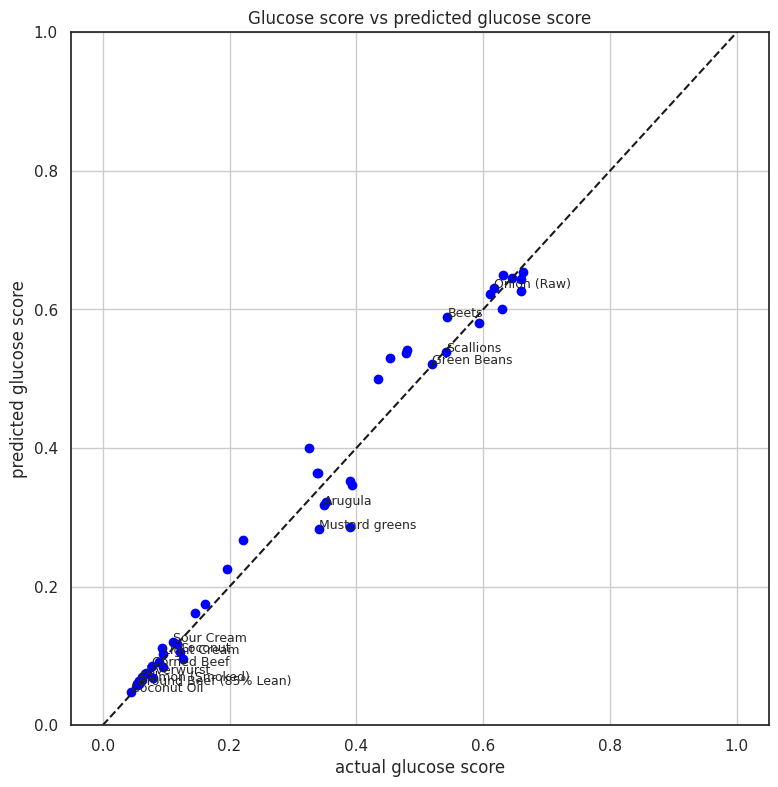

In [28]:
fig, ax = plt.subplots(figsize=(9,9))
foods = foods_data_validation['Food']
plt.scatter(foods_data_validation['Gs_'],preds,color = "blue")
for count, label, xx, yy in zip(np.arange(len(foods_data_validation)),foods, foods_data_validation['Gs_'],preds):
    if count % 4 == 0:
        plt.annotate(label, xy = (xx, yy),fontsize = 9)
plt.grid(True)
plt.ylim(0,1)
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('actual glucose score')
plt.ylabel('predicted glucose score')
plt.title('Glucose score vs predicted glucose score')
plt.show()

# 5. Predict on food data <a class="anchor"  id="predict"></a>

In [29]:
diet['protein_'] = diet['protein.1']
diet['protein_'] = diet['protein_'].astype(float)
diet['fat_'] = diet['fat.1']
diet['carbs_'] = diet['carbs.1']
diet['satiety_index'] = model_satiety.predict(diet)
diet['nutrient_density'] = model_nutden.predict(diet)
diet['glucose_score'] = model_glucose_score.predict(diet)

In [30]:
x=foods_data_validation['satiety_index']
y=foods_data_validation['nutrient_density_per_cal']
z=foods_data_validation['Gs_']
reg_plane = ols(formula = 'satiety_index ~ Gs_ + nutrient_density_per_cal',data= foods_data).fit()
reg_plane.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          satiety_index   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     595.2
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          8.21e-114
Time:                        06:38:32   Log-Likelihood:                 289.62
No. Observations:                 356   AIC:                            -573.2
Df Residuals:                     353   BIC:                            -561.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0558      0.019      2.966      0.003       0.019       0.093
Gs_                         -0.1201      0.025     -4.875      0.000      -0.169      -0.072
nutrient_density_per_cal     1.0199      0.031     32.710      0.000       0.959       1.081
==============================================================================
Omnibus:                       98.189   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.314
Skew:                           1.238   Prob(JB):                     8.30e-67
Kurtosis:                       6.793   Cond. No.                         7.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:

X = []
Y = []

for index, row in foods_data.iterrows():
    # add the bias term at the end of feature matrix for the intercept:
    X.append([float(row['nutrient_density_per_cal']), float(row['Gs_']), 1])
    Y.append(float(row['satiety_index']))

# use numpy arrays so that we can use linear algebra later
X = np.array(X)
Y = np.array(Y)

# Use Linear Algebra to solve, will give same coefficients as OLS regression above!
a = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
predictedY = np.dot(X, a)

# calculate the r-squared
SSres = Y - predictedY
SStot = Y - Y.mean()
rSquared = 1 - (SSres.dot(SSres) / SStot.dot(SStot))
print("the r-squared is: ", rSquared)
print("Coefficients:")
print("Intercept: ",a[2])
print("Nutrient Density: ",a[0])
print("Glucose Score: ",a[1])

the r-squared is:  0.7712883661779362
Coefficients:
Intercept:  0.05578897538678996
Nutrient Density:  1.0198704217316217
Glucose Score:  -0.12010315642119271


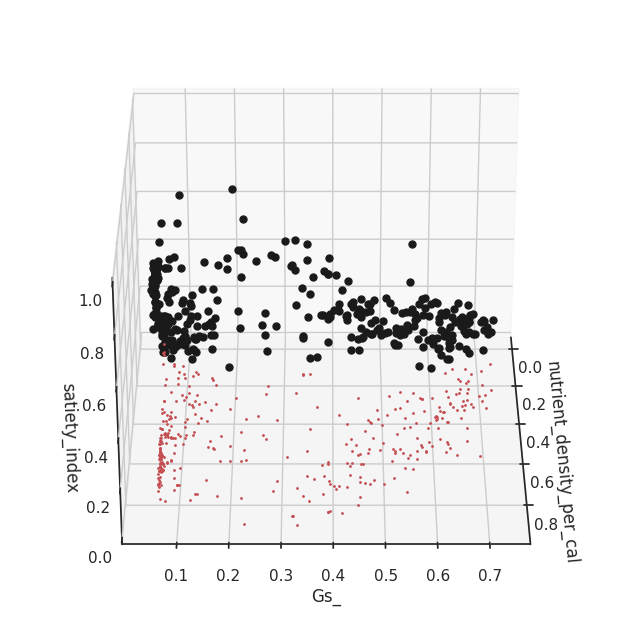

In [32]:
from IPython.display import HTML
from matplotlib import animation
from astropy.table import Table

foods_data_=Table.read('/kaggle/input/food-and-satiety-index/net carbs vs glucose score vs satiety index_data_.csv')
foods_data_['protein_'] = foods_data_['Protein %']/(foods_data_['Protein %']+foods_data_['Fat (%)']+foods_data_['Net Carb (%)'])
foods_data_['fat_'] = foods_data_['Fat (%)']/(foods_data['Protein %']+foods_data_['Fat (%)']+foods_data_['Net Carb (%)'])
foods_data_['carbs_'] = foods_data_['Net Carb (%)']/(foods_data['Protein %']+foods_data_['Fat (%)']+foods_data_['Net Carb (%)'])
foods_data_['satiety_index'] = foods_data_['satiety index score']
foods_data_['Gs_'] = foods_data_['Gs (%)']
foods_data_['nutrient_density_per_cal'] = foods_data_['Nutrient Density (Per Calorie)']
min_red=min(foods_data_['satiety_index'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')


ax.plot(foods_data_['nutrient_density_per_cal'], foods_data_['Gs_'], foods_data_['satiety_index'],'ko',markersize=5,linewidth=2)
# ax.plot(diet['nutrient_density'], diet['glucose_score'], diet['satiety_index'],'ko',markersize=7,linewidth=2,color='b')

m=ax.plot(foods_data_['nutrient_density_per_cal'], foods_data_['Gs_'], 'ro', markersize=1, color='r', zdir='z', zs=min_red)
# m=ax.plot(diet['nutrient_density'], diet['glucose_score'], 'ro', markersize=1, color='b', zdir='z', zs=min_red)

ax.set_xlabel('nutrient_density_per_cal')
ax.set_ylabel('Gs_')
ax.set_zlabel('satiety_index')




def animate(frame):
  ax.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=300, interval=50)
HTML(anim.to_html5_video())

# 6. Create food score <a class="anchor"  id="create"></a>

In this section I am going to weight the data and create daily averages, to understand how the satiety index, nutrient density and glucose scores affect my blood glucose on a macro level. ie Did I have a good day regarding food? How did that affect my daily average blood glucose levels?

In [33]:
def weighted_average(df,data_col,weight_col,by_col):
    ''' Now data_col can be a list of variables '''
    df_data = df[data_col].multiply(df[weight_col], axis='index')
    df_weight = pd.notnull(df[data_col]).multiply(df[weight_col], axis='index')
    df_data[by_col] = df[by_col]
    df_weight[by_col] = df[by_col]    
    result = df_data.groupby(by_col).sum() / df_weight.groupby(by_col).sum()
    return result

In [34]:
diet['fat.1']  = diet['fat.1'].astype(float)
diet['protein.1']  = diet['protein.1'].astype(float)
diet['total_grams'] = diet['fat'].astype(float)+diet['carbs'].astype(float)
diet.head()

,date,time,food,kcal,fat,carbs,protein,fat.1,carbs.1,protein.1,exercise,glucose_init,glucose_final,protein_,fat_,carbs_,satiety_index,nutrient_density,glucose_score,total_grams
0,31/01/2025,09:30,scrambled eggs,143.0,9.5,0.7,12.6,0.416667,0.030702,0.552632,0,6.5,7.0,0.552632,0.416667,0.030702,0.736488,0.630536,0.086665,10.2
1,31/01/2025,09:30,spinach leaves,7.0,0.1,1.1,0.9,0.047619,0.523810,0.428571,0,NaN,NaN,0.428571,0.047619,0.523810,0.752602,0.699957,0.452152,1.2
2,31/01/2025,09:30,salmon,140.0,7.9,0.0,16.1,0.329167,0.000000,0.670833,0,NaN,NaN,0.670833,0.329167,0.000000,0.786685,0.642437,0.063909,7.9
3,31/01/2025,12:00,coffee,86.0,3.4,8.5,5.5,0.195402,0.488506,0.316092,0,6.5,7.0,0.316092,0.195402,0.488506,0.616302,0.607124,0.420439,11.9
4,31/01/2025,12:40,pork steak,420.0,19.2,7.9,52.7,0.240602,0.098997,0.660401,0,6.5,7.0,0.660401,0.240602,0.098997,0.811086,0.683740,0.146018,27.1


In [35]:
diet_agg_scores = weighted_average(diet,['fat_','carbs_','protein_'],'total_grams',['date']).reset_index()
diet_agg_scores['date'] = pd.Categorical(diet_agg_scores['date'], ['31/01/2025','01/02/2025','02/02/2025','03/02/2025','04/02/2025','05/02/2025','06/02/2025','07/02/2025','08/02/2025','09/02/2025'])
diet_agg_scores = diet_agg_scores.sort_values(by='date')
diet_agg_scores['glucose_score'] = model_glucose_score.predict(diet_agg_scores)
diet_agg_scores['satiety_index'] = model_satiety.predict(diet_agg_scores)
diet_agg_scores['nutrient_density'] = model_nutden.predict(diet_agg_scores)
diet_agg_scores = diet_agg_scores.reset_index(drop=True)
diet_agg_scores.head(10)

,date,fat_,carbs_,protein_,glucose_score,satiety_index,nutrient_density
0,31/01/2025,0.299695,0.498248,0.202058,0.419276,0.459678,0.493168
1,01/02/2025,0.250068,0.478490,0.271442,0.410663,0.555881,0.564106
2,02/02/2025,0.359901,0.383893,0.256206,0.344421,0.517997,0.536147
3,03/02/2025,0.160110,0.653451,0.186440,0.518024,0.460700,0.481892
4,04/02/2025,0.204643,0.506739,0.288618,0.430882,0.584187,0.583725
5,05/02/2025,0.405381,0.357202,0.237417,0.324523,0.487296,0.512801
6,06/02/2025,0.414873,0.168276,0.416851,0.192633,0.661628,0.615247
7,07/02/2025,0.480616,0.214090,0.305293,0.223181,0.549822,0.545458
8,08/02/2025,0.256415,0.494791,0.248795,0.420139,0.527456,0.543081


<Axes: xlabel='glucose_score', ylabel='Density'>

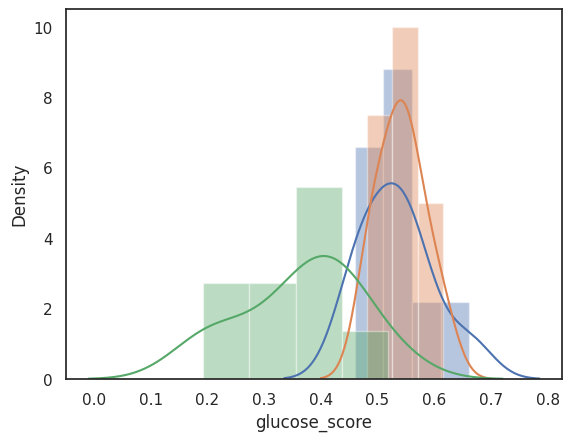

In [36]:
sns.distplot(diet_agg_scores['satiety_index'])
sns.distplot(diet_agg_scores['nutrient_density'])
sns.distplot(diet_agg_scores['glucose_score'])

create the score:

In [37]:
diet_agg_scores['food_score'] = diet_agg_scores['nutrient_density'] + (1-(2*diet_agg_scores['glucose_score'])) + diet_agg_scores['satiety_index']


# 7. Food score vs cgm <a class="anchor"  id="food"></a>

In [38]:
df_cv

,Date,mean,max,std,glucose_cv,CarbCategory
0,2025-01-31,6.808696,9.2,0.732510,0.107584,Normal
1,2025-02-01,7.001736,11.3,0.791511,0.113045,Normal
2,2025-02-02,6.732292,9.2,0.728082,0.108148,Normal
3,2025-02-03,7.027431,11.0,1.181473,0.168123,Normal
4,2025-02-04,6.827431,8.5,0.716360,0.104924,Normal
5,2025-02-05,6.446875,8.7,0.509756,0.079070,Lower
6,2025-02-06,6.562153,9.3,0.860954,0.131200,Lower
7,2025-02-07,6.425000,7.9,0.456740,0.071088,Lower
8,2025-02-08,6.677431,10.8,0.531779,0.079638,Lower
9,2025-02-09,6.459722,7.9,0.466565,0.072227,Lower


In [39]:
df_cv_ = df_cv[0:9].reset_index()
diet_agg_scores['glucose_cv'] = df_cv_['glucose_cv']
diet_agg_scores['CarbCategory'] = df_cv_['CarbCategory']
diet_agg_scores['glucose_mean'] = df_cv_['mean']
diet_agg_scores['glucose_std'] = df_cv_['std']
diet_agg_scores.head(12)

,date,fat_,carbs_,protein_,glucose_score,satiety_index,nutrient_density,food_score,glucose_cv,CarbCategory,glucose_mean,glucose_std
0,31/01/2025,0.299695,0.498248,0.202058,0.419276,0.459678,0.493168,1.114294,0.107584,Normal,6.808696,0.732510
1,01/02/2025,0.250068,0.478490,0.271442,0.410663,0.555881,0.564106,1.298661,0.113045,Normal,7.001736,0.791511
2,02/02/2025,0.359901,0.383893,0.256206,0.344421,0.517997,0.536147,1.365302,0.108148,Normal,6.732292,0.728082
3,03/02/2025,0.160110,0.653451,0.186440,0.518024,0.460700,0.481892,0.906544,0.168123,Normal,7.027431,1.181473
4,04/02/2025,0.204643,0.506739,0.288618,0.430882,0.584187,0.583725,1.306149,0.104924,Normal,6.827431,0.716360
5,05/02/2025,0.405381,0.357202,0.237417,0.324523,0.487296,0.512801,1.351051,0.079070,Lower,6.446875,0.509756
6,06/02/2025,0.414873,0.168276,0.416851,0.192633,0.661628,0.615247,1.891609,0.131200,Lower,6.562153,0.860954
7,07/02/2025,0.480616,0.214090,0.305293,0.223181,0.549822,0.545458,1.648917,0.071088,Lower,6.425000,0.456740
8,08/02/2025,0.256415,0.494791,0.248795,0.420139,0.527456,0.543081,1.230259,0.079638,Lower,6.677431,0.531779


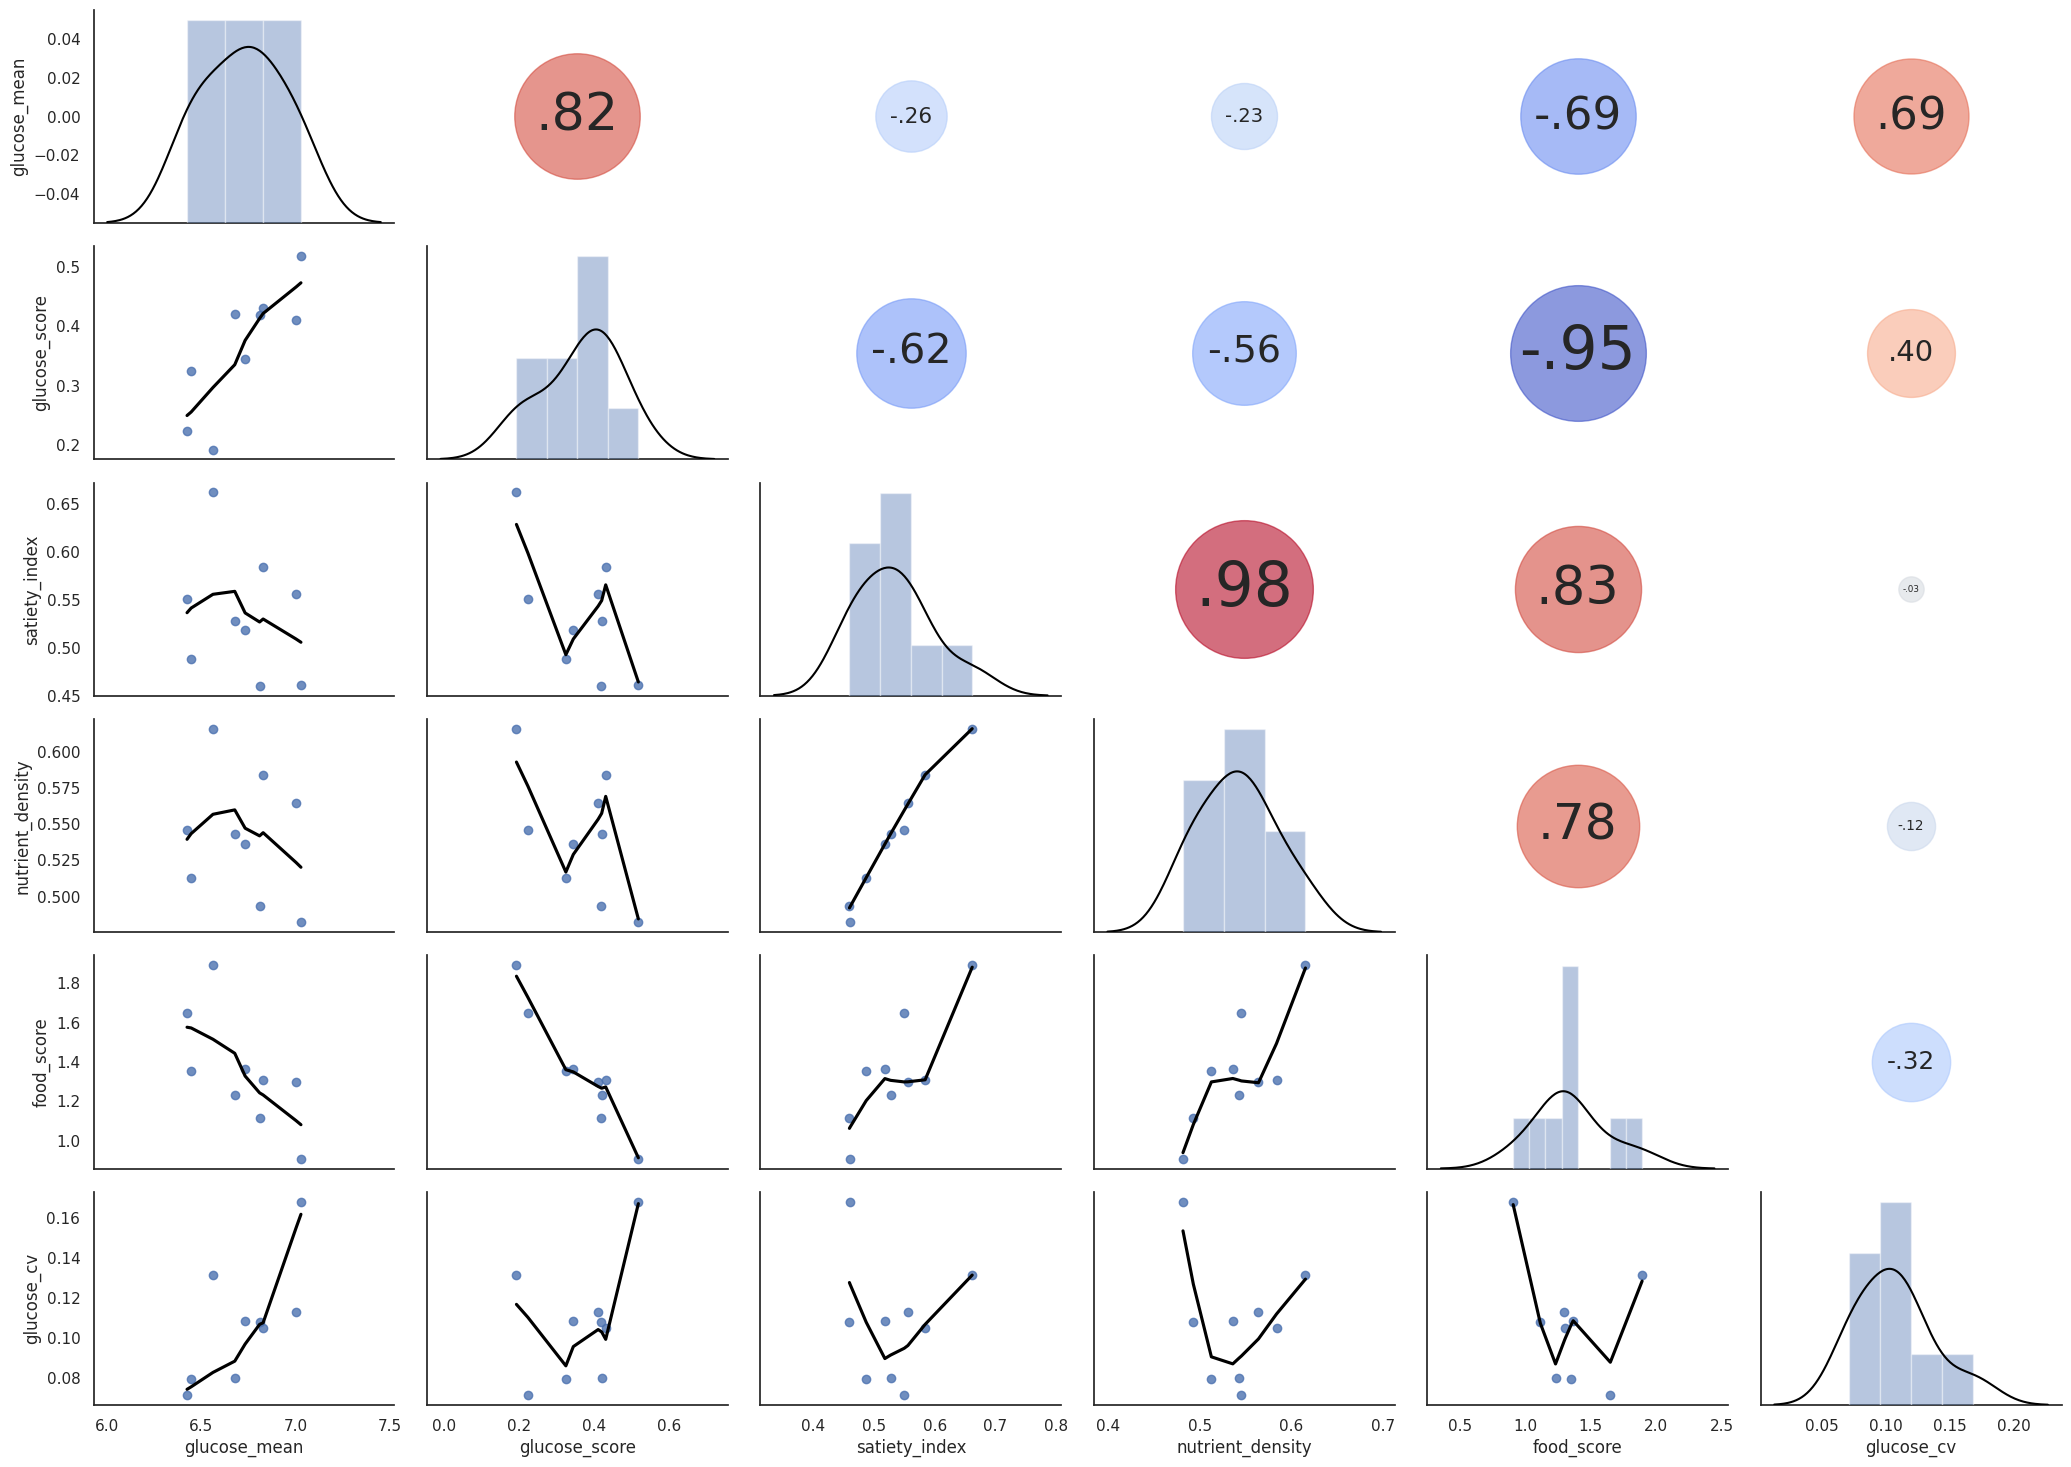

In [40]:
corr_data = diet_agg_scores[['glucose_mean','glucose_score','satiety_index','nutrient_density','food_score','glucose_cv','CarbCategory']]

sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(corr_data, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

Really thin data but the food score has a negative correlation with the daily glucose mean readings to the value of -0.69!

In [41]:
cv_si = ols(formula = 'glucose_mean ~ food_score',data= corr_data).fit()
cv_si.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           glucose_mean   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     6.379
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0395
Time:                        06:39:06   Log-Likelihood:                 4.3660
No. Observations:                   9   AIC:                            -4.732
Df Residuals:                       7   BIC:                            -4.338
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4333      0.287     25.926      0.000       6.755       8.111
food_score    -0.5276      0.209     -2.526      0.039      -1.021      -0.034
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   2.509
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.185
Skew:                          -0.171   Prob(JB):                        0.912
Kurtosis:                       2.386   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On really thin data, from the Adj R-squared you can see that the food score explains around 40% of my glucose mean values from the cgm. Looking at the coefficients you can see the intercept or starting point as 7.4 mmol/L daily average, while a unit food_score regarding my meals for the day will decrease that daily average by -0.5276 mmol/L.

In [42]:
# %%html
# <iframe width="700" height="500" src="urlhere" title="titlehere" frameborder="0"></iframe>